# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [301]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow.keras
import keras
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.layers import Conv2D, Reshape
from PIL import Image
from tensorflow.keras.backend import epsilon

### Change directory

In [0]:
project_path = "/content/drive/My Drive/Residency_9_Assignments/"
import os
os.chdir(project_path)

### Load the training data from train.csv file

In [0]:
racoontraindata=pd.read_csv('train_labels.csv')

### Print the shape of the train dataset

In [305]:
racoontraindata.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE=128

In [0]:
#!pip install patool
import patoolib
patoolib.extract_archive("images_racoon.rar", outdir="train")

patool: Extracting images_racoon.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/Residency_9_Assignments/images_racoon.rar"
patool:     with cwd='train'
patool: ... images_racoon.rar extracted to `train'.


'train'

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
import csv
with open('train_labels.csv', 'r') as csvfile:
    paths = []
    i=1
    coords = np.zeros((sum(1 for line in csvfile) -1, 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(reader, None)
    for col, row in enumerate(reader):
        path, image_width, image_height, imageclass, x0, y0, x1, y1 = row
        coords[col, 0] = int(x0) * IMAGE_SIZE / int(image_width) # Normalize bounding box by image size
        coords[col, 1] = int(y0) * IMAGE_SIZE / int(image_height) # Normalize bounding box by image size
        coords[col, 2] = int((int(x1) - int(x0))) * IMAGE_SIZE / int(image_width) # Normalize bounding box by image size
        coords[col, 3] = int((int(y1) - int(y0))) * IMAGE_SIZE / int(image_height)
        paths.append(path)


In [308]:
batch_images.shape,coords.shape

((173, 128, 128, 3), (173, 4))

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
  loc="train/images/"+f
  img = Image.open(loc) # Read image
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
  img = img.convert('RGB')
  batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

In [0]:
coords=coords[0:173]

In [311]:
len(coords)

173

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
ALPHA = 1.0
from tensorflow.keras.applications.mobilenet import MobileNet
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet

for layer in model.layers:
    layer.trainable = False


x = model.layers[-1].output

x = Conv2D(4, kernel_size=4, name="coords")(x)

x = Reshape((4,))(x)

model = Model(inputs=model.input, outputs=x)


In [313]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
gt = coords
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [0]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

model.fit(batch_images,gt,
            epochs=100,batch_size = 32,
            verbose=1)

Train on 173 samples
Epoch 1/100
173/173 [==============================] - 5s 28ms/sample - loss: 2725.4301 - IoU: 0.1073
Epoch 2/100
173/173 [==============================] - 4s 20ms/sample - loss: 629.8934 - IoU: 0.4406
Epoch 3/100
173/173 [==============================] - 4s 20ms/sample - loss: 667.7409 - IoU: 0.5377
Epoch 4/100
173/173 [==============================] - 3s 20ms/sample - loss: 553.0637 - IoU: 0.5396
Epoch 5/100
173/173 [==============================] - 4s 20ms/sample - loss: 345.1220 - IoU: 0.5782
Epoch 6/100
173/173 [==============================] - 4s 20ms/sample - loss: 273.1343 - IoU: 0.5847
Epoch 7/100
173/173 [==============================] - 4s 21ms/sample - loss: 236.6507 - IoU: 0.6133
Epoch 8/100
173/173 [==============================] - 4s 21ms/sample - loss: 192.7332 - IoU: 0.6622
Epoch 9/100
173/173 [==============================] - 4s 21ms/sample - loss: 165.9351 - IoU: 0.6933
Epoch 10/100
173/173 [==============================] - 4s 21ms/sampl

In [0]:
len(coords)

173

### Pick a test image from the given data

In [0]:
import cv2
filename = './train/images/raccoon-146.jpg'
unscaled = cv2.imread(filename)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape

In [0]:

image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
image.shape

(128, 128, 3)

In [0]:
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0]
region

array([ 21.523046,   6.597309,  95.82405 , 124.61007 ], dtype=float32)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

In [0]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)
print(x0,y0,x1,y1)

46 9 205 178


In [0]:
rt=cv2.rectangle(unscaled,(x0,y0),(x1,y1),(255,0,0),5)

In [0]:
from google.colab.patches import cv2_imshow

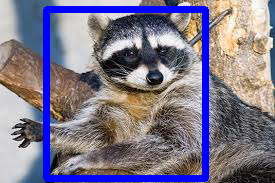

In [0]:
cv2_imshow(rt)

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Change your present working directory

In [0]:
project_path = "/content/drive/My Drive/Residency_9_Assignments/"
import os
os.chdir(project_path)

### Load your data file

In [0]:
tempdata=pd.read_csv('daily-minimum-temperatures-in-me.csv')

#### Plot data

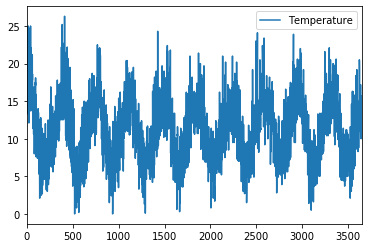

In [316]:
tempdata.plot()

#### Descibe your dataframe

In [317]:
tempdata.dtypes

Date            object
Temperature    float64
dtype: object

In [318]:
tempdata.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [319]:
tempdata.isnull().sum()

Date           0
Temperature    0
dtype: int64

#### Drop null values

#### Get the representation of the distribution of data in the form of histogram

(array([ 53., 181., 564., 862., 830., 670., 347., 102.,  32.,   9.]),
 array([ 0.  ,  2.63,  5.26,  7.89, 10.52, 13.15, 15.78, 18.41, 21.04,
        23.67, 26.3 ]),
 <a list of 10 Patch objects>)

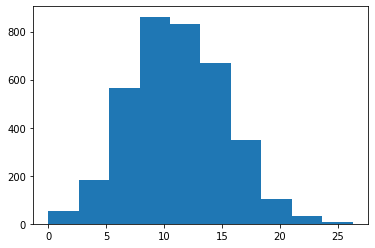

In [320]:
plt.hist(tempdata['Temperature'])

#### Check the maximum and minimum values

In [321]:
print('Min', np.min(tempdata))
print('Max', np.max(tempdata))

Min Date           1981-01-01
Temperature             0
dtype: object
Max Date           1990-12-31
Temperature          26.3
dtype: object


### Normalize the data

In [0]:
Temperaturedata=tempdata[['Temperature']]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(Temperaturedata)

#### Check the maximum and minimum values of scaled data

In [323]:
print('Min', np.min(scaled_data))
print('Max', np.max(scaled_data))

Min 0.0
Max 1.0


#### Look into some of the scaled values

In [324]:
scaled_data[0:5]

array([[0.78707224],
       [0.68060837],
       [0.7148289 ],
       [0.55513308],
       [0.60076046]])

### Split data into Training and Testing

In [0]:
train_size = int(len(scaled_data) * 0.70)
test_size = len(scaled_data - train_size)

#### Print train and test size

In [326]:
train, test = scaled_data[0:train_size, :], scaled_data[train_size: len(scaled_data), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
#window - how long the sequence will be
def create_dataset(dataset, window=1):
    
    dataX, dataY = [], []
    
    for i in range(len(dataset)-window):
        
        a = dataset[i:(i+window), 0]
        dataX.append(a)
        dataY.append(dataset[i + window, 0])
    
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [0]:
#Create Input and Output
window_size = 1
X_train, y_train = create_dataset(train, window_size)
X_test, y_test = create_dataset(test, window_size)

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [329]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2554, 1, 1)
(1094, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [0]:
tempmodel = tf.keras.Sequential()
tempmodel.add(tf.keras.layers.LSTM(32, input_shape=(window_size, 1)))
tempmodel.add(tf.keras.layers.Dense(1))
tempmodel.compile(optimizer='adam', loss='mse')

### Summarize your model

In [331]:
tempmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [332]:
tempmodel.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), batch_size=32)

Train on 2554 samples, validate on 1094 samples
Epoch 1/200
2554/2554 [==============================] - 2s 769us/sample - loss: 0.1077 - val_loss: 0.0394
Epoch 2/200
2554/2554 [==============================] - 0s 108us/sample - loss: 0.0184 - val_loss: 0.0134
Epoch 3/200
2554/2554 [==============================] - 0s 106us/sample - loss: 0.0141 - val_loss: 0.0128
Epoch 4/200
2554/2554 [==============================] - 0s 106us/sample - loss: 0.0133 - val_loss: 0.0117
Epoch 5/200
2554/2554 [==============================] - 0s 120us/sample - loss: 0.0125 - val_loss: 0.0110
Epoch 6/200
2554/2554 [==============================] - 0s 131us/sample - loss: 0.0118 - val_loss: 0.0103
Epoch 7/200
2554/2554 [==============================] - 0s 132us/sample - loss: 0.0112 - val_loss: 0.0098
Epoch 8/200
2554/2554 [==============================] - 0s 131us/sample - loss: 0.0108 - val_loss: 0.0093
Epoch 9/200
2554/2554 [==============================] - 0s 121us/sample - loss: 0.0105 - val_lo

## Make Predictions and Evaluate your model

In [0]:
myInput = np.reshape(scaler.transform(pd.DataFrame({"Temperature":[20]})), 1,1)

In [0]:
temp=np.reshape(myInput, (1, 1, 1))

In [335]:
temp.shape

(1, 1, 1)

In [0]:
predict=tempmodel.predict(temp)

In [337]:
float(scaler.inverse_transform(predict))

17.23245620727539

In [338]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = tempmodel.predict(X_train, batch_size=1)

tempmodel.reset_states()

testPredict = tempmodel.predict(X_test, batch_size=1)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.64 RMSE
Test Score: 2.50 RMSE


## Plot the results

In [0]:
trainPredict = tempmodel.predict(X_train)
testPredict = tempmodel.predict(X_test)
trainPredict = trainPredict.reshape(-1,1)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = testPredict.reshape(-1,1)
testPredict = scaler.inverse_transform(testPredict)

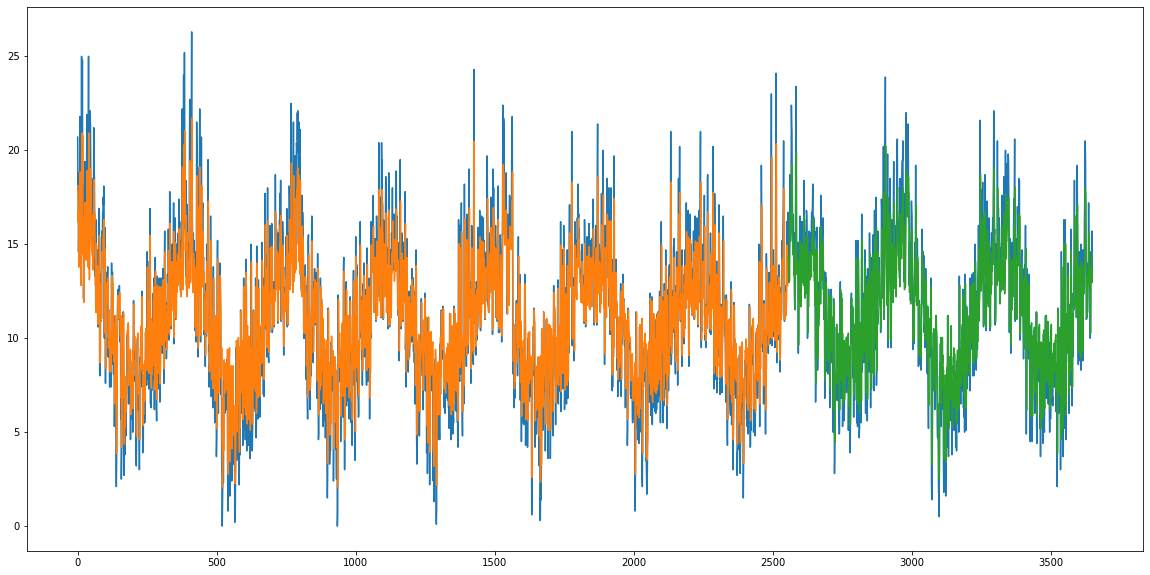

In [0]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_size:len(trainPredict)+window_size, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window_size*2):len(scaled), :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()